In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

In [3]:
import torch.nn as nn
import torch

In [4]:
from utils import MnistData
from models import ModelManager, ModelType

In [251]:
model_loaded = ModelManager.get_trained(ModelType.MnistCnnPatt)


In [ ]:
data = MnistData(True)

In [60]:
def max_norm(t: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.abs(t))

In [217]:
def solve_for_targeted(model, benign_image, target_label, c_lambda):
    step_size = 1e-2
    #adv = benign_image + (torch.rand(benign_image.shape) - 0.5) * 1e-1
    #adv = benign_image
    adv = torch.zeros(benign_image.shape)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    norm = nn.L1Loss(reduction='mean')
    # TODO: implement L-BFGS instead of GD
    for _ in range(100):
        adv.requires_grad = True
        if adv.grad is not None:
            adv.grad.zero_()
        loss = c_lambda * norm(adv.unsqueeze(0), benign_image.unsqueeze(0)) \
            + loss_fn(model(adv.unsqueeze(0)), torch.Tensor([target_label]).type(torch.long))
        #loss = loss_fn(model(adv.unsqueeze(0)), torch.Tensor([target_label]).type(torch.long))
        loss.backward()
        new_adv = MnistData.clip_for_image(adv - step_size * adv.grad.apply_(lambda x: 1 if x >= 0 else -1))
        adv = new_adv
    #MnistData.display(adv)
    #pred = MnistData.get_prediction(model, adv)
    #print(f'pred: {pred[0]}; target: {target_label}')
    if MnistData.get_prediction(model, adv)[0] == target_label:
        return adv
    return None
    


In [241]:
def solve_for_adv(model, benign_image, label, worst_case=False) -> torch.Tensor:
    # if MnistData.get_prediction(model, benign_image) != label:
    #     return benign_image
    # Line search for \lambda value (c in original paper)
    advs = []
    for i in [j for j in range(10) if j != label]:
        #print(f'\tTrying label {i}')
        c_lambda = 100
        adv = None
        while adv is None:
            #print(f'\tc_lamda = {c_lambda}')
            adv = solve_for_targeted(model, benign_image, i, c_lambda)
            c_lambda *= 0.9
        advs.append(adv)

    norm = nn.MSELoss(reduction='sum')
    # return
    norms = []
    for adv in advs:
        norms.append(norm(benign_image, adv))
        #norms.append(norm(benign_image, adv))
    if worst_case:
        maxout = max(norms)
        for i in range(len(advs)):
            if norms[i] == maxout:
                return advs[i]
    else:
        minout = min(norms)
        for i in range(len(advs)):
            if norms[i] == minout:
                return advs[i]

In [252]:
benign_images, labels = data.get_training_batch(1)
altered_training_images = []

for i in range(len(labels)):
    print(f'--- {i} ---')
    benign_image = benign_images[i]
    #MnistData.display(benign_image)
    label = labels[i]
    altered_training_images.append(solve_for_adv(model_loaded, benign_image, label))

#altered_training_images = torch.Tensor(altered_training_images)

--- 0 ---


In [253]:
possible_adversarials = MnistData.get_adversarials(model_loaded, benign_images, labels, altered_training_images)
len(possible_adversarials)

1

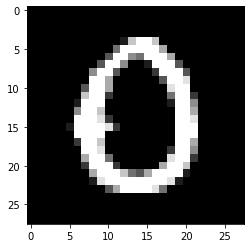

+++++


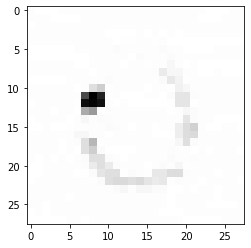

=====


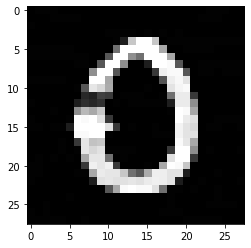

Label: 0, Prediction: 2, Confidence: 0.993943989276886
Original prediction: 0, Original confidence: 1.0


In [254]:
MnistData.show_adversarial(possible_adversarials, benign_images, altered_training_images, 0)